## Preparing Data 

#### download frm : [Name Data](https://download.pytorch.org/tutorial/data.zip)

###### Included in the data/names directory are 18 text files named as “[Language].txt”. Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

######  We’ll end up with a dictionary of lists of names per language, {language: [names ...]}. The generic variables “category” and “line” (for language and name in our case) are used for later extensibility.

In [5]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

data_dir = "./data/names/*.txt"
def findFiles(filePath):
    return glob.glob(filePath)

print("Files \n", findFiles(data_dir), "\n")

import unicodedata, string

all_letters = string.ascii_letters+ " .,;'"
n_letters = len(all_letters)

# Unicode to ascii 
def unicode2ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn'
                  and c in all_letters)

print(unicode2ascii('Ślusàrski'))

# Build category dict, list of names per language 
category_lines = {}
all_categories = []

#Read file and line split 
def readLine(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode2ascii(line) for line in lines]

for fileName in findFiles(data_dir):
    category = fileName.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLine(fileName)
    category_lines[category] = lines

n_categories = len(all_categories)

Files 
 ['./data/names/Arabic.txt', './data/names/Chinese.txt', './data/names/Czech.txt', './data/names/Dutch.txt', './data/names/English.txt', './data/names/French.txt', './data/names/German.txt', './data/names/Greek.txt', './data/names/Irish.txt', './data/names/Italian.txt', './data/names/Japanese.txt', './data/names/Korean.txt', './data/names/Polish.txt', './data/names/Portuguese.txt', './data/names/Russian.txt', './data/names/Scottish.txt', './data/names/Spanish.txt', './data/names/Vietnamese.txt'] 

Slusarski


## Turning Names Into Tensors 
#### Letter -> One hot Vector 
#### Word -> 2d matrix of all One hot Vectors 
Extra dim in pytorch, coz it assumes everything in minibatch. Thus 1 minibatch here



In [15]:
import torch

# Find letter Index from all_letters
def letter2Index(letter):
    return all_letters.find(letter)

# Create tensor of letter (1Xn_letters)- just to understand 
def letter2Tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter2Index(letter)] = 1
    return tensor

# Create tensor of line ( line_length X 1 X n_letters)  - one hot vector stack of line
def line2Tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter2Index(letter)] = 1
    return tensor


print(letter2Tensor('J'))

print(line2Tensor('Jones').size())

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
torch.Size([5, 1, 57])


## Creating the Network 
##### This RNN module (mostly copied from the PyTorch for Torch users tutorial) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.


![picture alt](https://i.imgur.com/Z2xbySO.png)

In [20]:
import torch.nn as nn 
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
               
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i20 = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input,hidden), 1)
        hidden = self.i2h(combined)
        # Output : probability of each language 
        output = self.softmax(self.i20(combined))
        return output, hidden 
    # Initialise hidden with zeros, as forward step needs input and previous hidden
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
        

In [21]:
# Using rnn forward above : 
ingput  = letter2Tensor('S')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(ingput, hidden)

print(output)
# To optimize we use line tensor, so as not to create a tensor for each letter :
# To do : further optimize by batches of tensor 

ingput = line2Tensor('Saleem')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(ingput[0], hidden)

# output is 1 X N categories where every value is likelihood of each category
print(output)

tensor([[-2.9141, -2.8426, -2.9305, -2.8069, -2.8198, -2.9525, -2.8267,
         -2.9131, -2.9244, -3.0088, -2.8475, -2.9576, -2.8590, -2.9241,
         -2.8606, -2.9203, -2.7803, -2.9725]])
tensor([[-2.9141, -2.8426, -2.9305, -2.8069, -2.8198, -2.9525, -2.8267,
         -2.9131, -2.9244, -3.0088, -2.8475, -2.9576, -2.8590, -2.9241,
         -2.8606, -2.9203, -2.7803, -2.9725]])


(tensor([[-2.7803]]), tensor([[ 16]]))

## Training 
#### Preparing for Training : 

In [26]:
# use tensor.topk(k) to get highest value, for interpreting the output 
# return top valu and index
def catFromOutput(output):
    top_n, top_i  = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

catFromOutput(output)

('Spanish', 16)

In [77]:
category = randomChoice(all_categories)
print(category)
print(all_categories.index(category))
line = randomChoice(category_lines[category])
print(line)

Portuguese
13
Madeira


In [67]:
# Quickly get training sample : Name, language 
import random 
def randomChoice(l) :
    return l[random.randint(0, len(l)-1)]

def randomTraininSample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line2Tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTraininSample()
    print('category =', category, '/ line =', line)
    
    

category = English / line = Kromberg
category = English / line = Slade
category = Vietnamese / line = Luc
category = English / line = Bryan
category = Korean / line = Yun
category = French / line = Lambert
category = Vietnamese / line = Sai
category = Czech / line = Sarna
category = Greek / line = Alexandropoulos
category = Russian / line = Saihanov


#### Actually Training The Network
##### define loss function - using negative log likelihood loss 

> Each loop of training will:

> * Create input and target tensors
> * Create a zeroed initial hidden state
> * Read each letter in and
> * Keep hidden state for next letter
> * Compare final output to target
> * Back-propagate
> * Return the output and loss

In [78]:
criterion = nn.NLLLoss()

lr = 0.05

def train(cat_tensor, line_tensor):
    print("catt",cat_tensor,"lint", line_tensor)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    print('....................', output.size(), cat_tensor.size())
    loss = criterion(output, cat_tensor)
    loss.backward()
    print("loss", loss.item())
    
    # Add parameter gradient *lr to update weight 
    for p in rnn.parameters():
        p.data.add_(-lr, p.grad.data)
    
    return output, loss.item()

In [79]:
# Run train with train data and print output also average loss 
import time 
import math 

n_iters = 100 #10000
print_every = 1 # 5000
plot_every = 1 

# Keep Track of losses for plotting 

current_loss =0 ; 
all_losses = [];

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters +1) :
    category, line, category_tensor, line_tensor = randomTraininSample()
    
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss 
    
    #Print iter, name, loss and guess 
    if iter % print_every == 0:        
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0




catt tensor([ 2]) lint tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  

           0.,  0.]]])
.................... torch.Size([1, 18]) torch.Size([1])
loss nan
39 39% (0m 0s) nan So / Vietnamese ✗ (Korean)
catt tensor([ 0]) lint tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
           0.,  

catt tensor([ 5]) lint tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  

## Plotting Results 


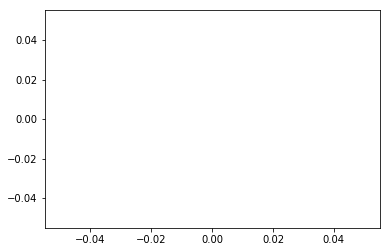

In [61]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

In [54]:
all_losses

[nan, nan, nan, nan, nan]

In [64]:
category, line, cat_tensor, lin_tensor = randomTraininSample()
    

In [66]:
cat_tensor

tensor([ 15])